In [1]:
from google.colab import drive
import os
import json
import numpy as np
from PIL import Image
from tqdm import tqdm

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import json
import cv2
import re
import numpy as np

# Paths to videos and labels
videos_path = "/content/drive/MyDrive/NUS_ISS_Talent_Experience_Resumes/cholect50-challenge-val/videos"
labels_path = "/content/drive/MyDrive/NUS_ISS_Talent_Experience_Resumes/cholect50-challenge-val/labels"

# Load verb (action) mapping from label_mapping.txt
verb_mapping = {}
with open(os.path.join('/content/drive/MyDrive/NUS_ISS_Talent_Experience_Resumes/cholect50-challenge-val/label_mapping.txt'), 'r') as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith('#'):  # skip comments/headers
            continue
        parts = line.split(',')
        triplet_id = int(parts[0])
        verb_id = int(parts[2])  # 3rd column = verb ID (as per CholecT50 format)
        verb_mapping[triplet_id] = verb_id

X = []
Y = []

# Loop through all video folders
for vid_folder in sorted(os.listdir(videos_path)):
    vid_path = os.path.join(videos_path, vid_folder)
    if not os.path.isdir(vid_path):
        continue

    # Corresponding label JSON
    label_file = f"{vid_folder}.json"
    label_path = os.path.join(labels_path, label_file)
    if not os.path.exists(label_path):
        print(f"Warning: {label_path} not found, skipping {vid_folder}")
        continue

    # Load JSON labels
    with open(label_path, 'r') as f:
        data = json.load(f)
    annotations = data['annotations']

    # Build frame_number -> verb_id list
    frame_verb = {}
    for frame_id, triplets in annotations.items():
        frame_number = int(frame_id)
        verbs_in_frame = []

        for triplet in triplets:
            triplet_id = triplet[0]
            verb_id = verb_mapping.get(triplet_id, -1)
            if verb_id != -1:
                verbs_in_frame.append(verb_id)

        # Only store frames that have at least one valid verb
        if len(verbs_in_frame) > 0:
            frame_verb[frame_number] = verbs_in_frame

    # Process frames in this video
    frame_files = sorted([f for f in os.listdir(vid_path) if f.endswith('.png')])
    for frame_file in frame_files:
        match = re.match(r"(\d+)", frame_file)
        if not match:
            continue
        frame_number = int(match.group(1))

        # Skip frames without a verb
        if frame_number not in frame_verb:
            continue

        verb_id = frame_verb[frame_number][0]  # use first verb if multiple

        # Load image
        img_path = os.path.join(vid_path, frame_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        X.append(img)
        Y.append(verb_id)

# Convert to numpy arrays
X = np.array(X, dtype=np.float32) / 255.0
Y = np.array(Y, dtype=np.int64)

print(f"✅ Total frames processed: {len(X)}")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")
print(f"Unique verbs/actions (set(Y)):", sorted(set(Y)))

✅ Total frames processed: 1209
X shape: (1209, 224, 224, 3), Y shape: (1209,)
Unique verbs/actions (set(Y)): [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(9)]


In [3]:
import cv2
import numpy as np
from collections import Counter
import albumentations as A

print("Original class distribution:")
print(Counter(Y))

unique, counts = np.unique(Y, return_counts=True)
max_count = np.max(counts)
upsample_limit = 200

aug_pipeline = A.Compose([
    A.RandomCrop(width=200, height=200, p=1.0),   # crop
    A.Rotate(limit=30, p=1.0)                     # rotate
])

X_balanced = []
Y_balanced = []

for cls in unique:
    cls_indices = np.where(Y == cls)[0]
    X_cls = X[cls_indices]
    Y_cls = Y[cls_indices]

    X_balanced.extend(X_cls)
    Y_balanced.extend(Y_cls)

    n_samples_needed = min(max_count - len(X_cls), upsample_limit)

    for _ in range(n_samples_needed):
        idx = np.random.randint(0, len(X_cls))
        img = X_cls[idx]
        img_aug = aug_pipeline(image=img)['image']

        # Resize back to 224x224
        img_aug_resized = cv2.resize(img_aug, (224, 224))

        X_balanced.append(img_aug_resized)
        Y_balanced.append(cls)

X_balanced = np.array(X_balanced, dtype=np.float32)
Y_balanced = np.array(Y_balanced, dtype=np.int64)

Original class distribution:
Counter({np.int64(1): 265, np.int64(0): 218, np.int64(3): 160, np.int64(2): 128, np.int64(4): 108, np.int64(5): 104, np.int64(6): 98, np.int64(9): 70, np.int64(7): 58})


1178
Label: 4


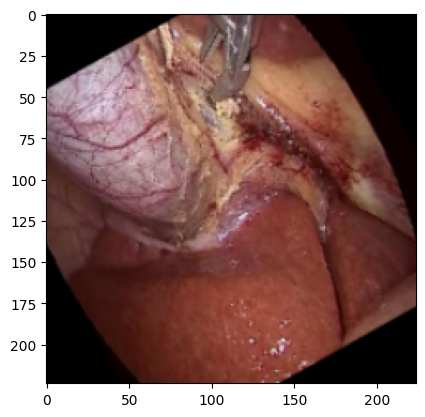

In [6]:
import matplotlib.pyplot as plt
idx = np.random.randint(len(X_balanced))
plt.imshow(X_balanced[idx])
print(idx)
print("Label:", Y_balanced[idx])

In [7]:
import numpy as np

# Original labels
unique_labels = sorted(np.unique(Y_balanced))  # [0,1,2,3,4,5,6,7,9]
label_map = {old:i for i, old in enumerate(unique_labels)}
print("Label mapping:", label_map)

# Apply mapping
Y_balanced_mapped = np.array([label_map[y] for y in Y_balanced])

# Now labels are continuous 0..8
num_classes = len(unique_labels)

Label mapping: {np.int64(0): 0, np.int64(1): 1, np.int64(2): 2, np.int64(3): 3, np.int64(4): 4, np.int64(5): 5, np.int64(6): 6, np.int64(7): 7, np.int64(9): 8}


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(
    X_balanced, Y_balanced_mapped, test_size=0.3, stratify=Y_balanced_mapped, random_state=42
)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=42
)

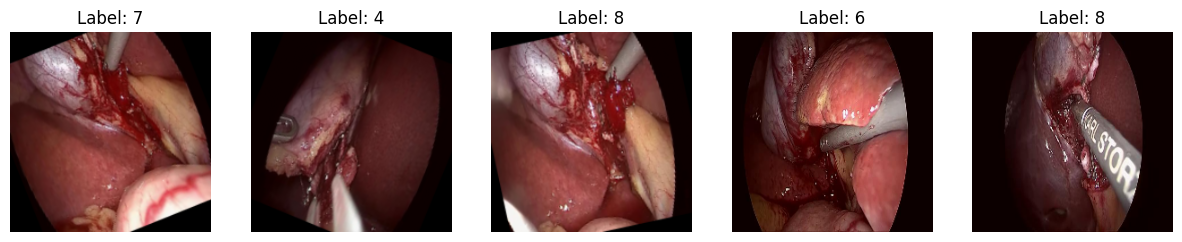

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

for i in range(5):
    plt.subplot(1, 5, i+1)
    # Clip values to [0,1] in case augmentation/resizing caused values >1
    plt.imshow(np.clip(X_train[i], 0, 1))
    plt.title(f"Label: {Y_train[i]}")
    plt.axis('off')

plt.show()

Simple Model

In [10]:
num_classes = len(np.unique(Y_train))  # This should now include class 9
print("Num classes:", num_classes)

Num classes: 9


In [29]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = (224, 224, 3)

inputs = Input(shape=input_shape)

x = Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2,2))(x)

x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,235,497 (12.34 MB)

 Trainable params: 3,235,497 (12.34 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=5,
    batch_size=4
)

Epoch 1/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 104s 246ms/step - accuracy: 0.1742 - loss: 2.1512 - val_accuracy: 0.4342 - val_loss: 1.5184
Epoch 2/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 103s 249ms/step - accuracy: 0.4833 - loss: 1.4041 - val_accuracy: 0.5854 - val_loss: 1.1576
Epoch 3/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 102s 245ms/step - accuracy: 0.7095 - loss: 0.8501 - val_accuracy: 0.6331 - val_loss: 1.0508
Epoch 4/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 142s 246ms/step - accuracy: 0.8472 - loss: 0.4343 - val_accuracy: 0.6303 - val_loss: 1.3585
Epoch 5/5
416/416 ━━━━━━━━━━━━━━━━━━━━ 150s 267ms/step - accuracy: 0.8834 - loss: 0.3266 - val_accuracy: 0.6246 - val_loss: 1.3889


In [30]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=2,
    batch_size=16
)

Epoch 1/2
104/104 ━━━━━━━━━━━━━━━━━━━━ 96s 911ms/step - accuracy: 0.2115 - loss: 2.1213 - val_accuracy: 0.3922 - val_loss: 1.5880
Epoch 2/2
104/104 ━━━━━━━━━━━━━━━━━━━━ 137s 861ms/step - accuracy: 0.4837 - loss: 1.4598 - val_accuracy: 0.5770 - val_loss: 1.2167


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input

input_shape = (224, 224, 3)
num_classes = len(np.unique(Y_train))

# Input
inputs = Input(shape=input_shape)

# MobileNetV3 Small backbone
base_model = tf.keras.applications.MobileNetV3Small(
    input_tensor=inputs,
    include_top=False,
    weights='imagenet'
)

# Feature extraction
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 1,091,449 (4.16 MB)

 Trainable params: 1,078,185 (4.11 MB)

 Non-trainable params: 13,264 (51.81 KB)

In [13]:
np.unique(Y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = (224, 224, 3)

inputs = Input(shape=input_shape)

x = Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2,2))(x)

x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,912,425 (49.26 MB)

 Trainable params: 12,912,425 (49.26 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=5,
    batch_size=4
)

Epoch 1/5
274/416 ━━━━━━━━━━━━━━━━━━━━ 1:20 565ms/step - accuracy: 0.1237 - loss: 2.2248